In [80]:
import numpy as np
import pandas as pd
from scipy import stats
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from joblib import Parallel, delayed
import matplotlib.pyplot as plt
%matplotlib inline

## 1. Loading in datasets

#### (a) Dataset for Credit Default Swap spreads

In [2]:
cds_DF = pd.read_csv("datasets/cds.csv", parse_dates=['Date'])
cds_DF.head()

,Date,Ticker,Company,PX1,PX2,PX3,PX4,PX5,PX6,PX7,PX8,PX9,PX10
0,2015-01-01,A,Agilent Technologies Inc,14.850,25.05,39.055,73.715,86.30,111.305,125.905,144.300,158.600,168.195
1,2015-01-02,A,Agilent Technologies Inc,14.855,25.15,39.160,73.600,86.40,111.510,126.100,144.375,158.775,168.375
2,2015-01-05,A,Agilent Technologies Inc,13.455,24.96,39.310,70.200,88.26,111.970,125.060,143.165,157.385,166.825
3,2015-01-06,A,Agilent Technologies Inc,15.535,24.88,39.300,72.680,91.10,116.610,130.890,150.365,165.655,175.885
4,2015-01-07,A,Agilent Technologies Inc,15.215,25.50,40.270,73.880,92.50,117.780,131.940,151.145,166.215,176.295


## 2. Processing data

In [149]:
#create a dictionary with ticker names and corresponding dataframe created by create_correct_dataframe()
#Tickers that have less than 1747 (most frequent) observations and/or have less than 1000 different valued observations are removed
ticks_DF_dict = {}
for tick in cds_DF.groupby('Ticker').size()[cds_DF.groupby('Ticker').size() >= 1747].index:
    if len(cds_DF[cds_DF['Ticker'] == tick]['PX1'].unique()) > 1000:
        ticks_DF_dict[tick] = cds_DF[cds_DF['Ticker'] == tick].set_index("Date")

## 3. Augmented Dickey Fuller testing for stationarity

In [148]:
dickeys=dict()
for tick, DF in ticks_DF_dict.items():
    dickey_test = adfuller(DF['PX1'].diff().dropna())
    dickeys[tick] = (dickey_test[0], dickey_test[1])
    print(f"{tick}, t-stat:{dickey_test[0]:.5g}, p-val:{dickey_test[1]:.5g}")

A, t-stat:-10.515, p-val:1.0013e-18
AALLN, t-stat:-7.4447, p-val:5.8812e-11
AAPL, t-stat:-11.659, p-val:1.9547e-21
ABC, t-stat:-19.756, p-val:0
ABESM, t-stat:-6.7803, p-val:2.5096e-09
ABIBB, t-stat:-8.8115, p-val:1.9853e-14
ABT, t-stat:-24.263, p-val:0
ABXCN, t-stat:-8.2802, p-val:4.5411e-13
ACAFP, t-stat:-10.433, p-val:1.5946e-18
ACEIM, t-stat:-7.824, p-val:6.5551e-12
ACFP, t-stat:-8.5062, p-val:1.201e-13
ADENVX, t-stat:-14.122, p-val:2.419e-26
ADM, t-stat:-13.949, p-val:4.741e-26
ADNA, t-stat:-43.29, p-val:0
ADP, t-stat:-18.158, p-val:2.4653e-30
ADSGR, t-stat:-9.3397, p-val:8.8628e-16
AEGON, t-stat:-9.9449, p-val:2.6045e-17
AES, t-stat:-11.821, p-val:8.4354e-22
AET, t-stat:-23.147, p-val:0
AFG, t-stat:-13.396, p-val:4.6713e-25
AGSBB, t-stat:-45.337, p-val:0
AIFP, t-stat:-9.2355, p-val:1.6349e-15
AIG, t-stat:-12.013, p-val:3.1519e-22
AIRFP, t-stat:-9.5196, p-val:3.0907e-16
AKZANA, t-stat:-10.696, p-val:3.6145e-19
ALL, t-stat:-10.744, p-val:2.7724e-19
ALLRNV, t-stat:-17.616, p-val:3.85

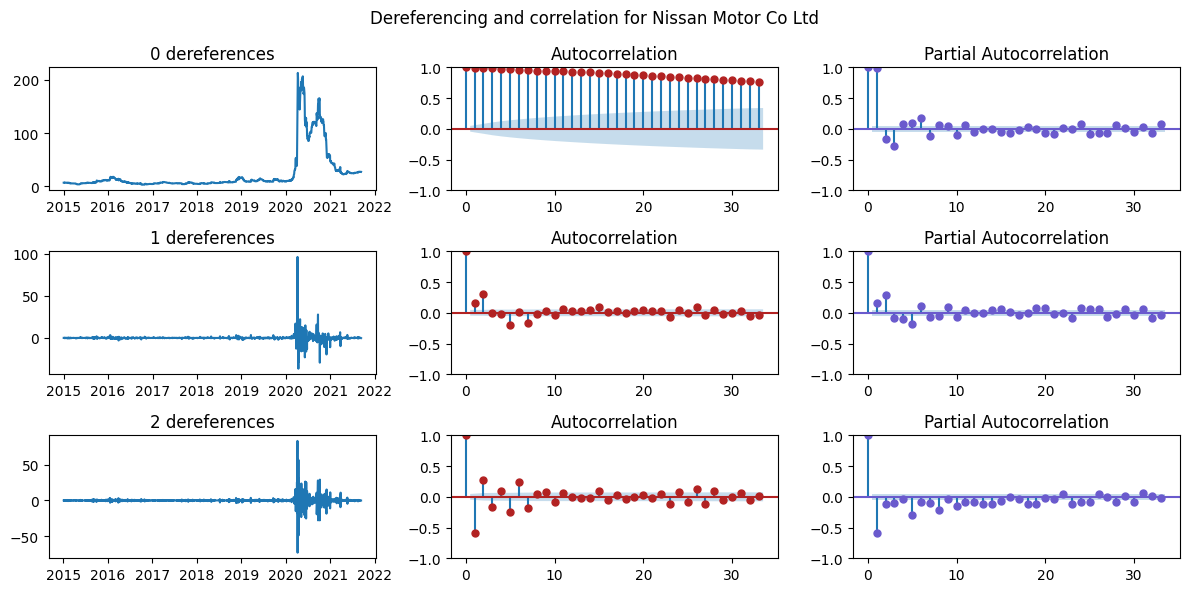

In [87]:
def plotOSandAC(tDF, dereferences, colname, type="BOTH"):
    """Plots the (dereferenced) series vs the autocorrelation, to see what amount of dereferencing
    is needed before the time-series is stationary."""
    assert dereferences > 0, "Amount of dereferences must be greater than 0"
    assert type in ['ACF', 'PACF', 'BOTH'], "Plot-type must be one of: 'PACF' or 'ACF' 'BOTH'"
    
    am_vertical_subplots = min(3, dereferences+1)
    am_horizontal_subplots = 2
    if type == 'BOTH':
        am_horizontal_subplots = 3
    
    fig, axes = plt.subplots(am_vertical_subplots, am_horizontal_subplots, figsize=(4*am_horizontal_subplots,2*am_vertical_subplots))
    for i in range(am_vertical_subplots):
        temp_tseries = tDF[colname]
        for amount_dereferencing in range(dereferences - (am_vertical_subplots-1-i)):
            temp_tseries = temp_tseries.diff().dropna()
        axes[i, 0].plot(temp_tseries); axes[i, 0].set_title(f'{dereferences - (am_vertical_subplots-1-i)} dereferences')
        if type == "ACF":
            plot_acf(temp_tseries, ax=axes[i, 1], color='firebrick')
        elif type == "PACF":
            plot_pacf(temp_tseries, ax=axes[i, 1], color='slateblue')
        elif type == "BOTH":
            plot_acf(temp_tseries, ax=axes[i, 1], color='firebrick')
            plot_pacf(temp_tseries, ax=axes[i, 2], color='slateblue')
    fig.suptitle(f"Dereferencing and correlation for {tDF.Company.iloc[0]}")
    plt.tight_layout()

plotOSandAC(ticks_DF_dict['NSANY'], 2, 'PX1', type="BOTH")

## 5. Defining functions to perform different kinds of forecasting for (AR)(I)(MA) models

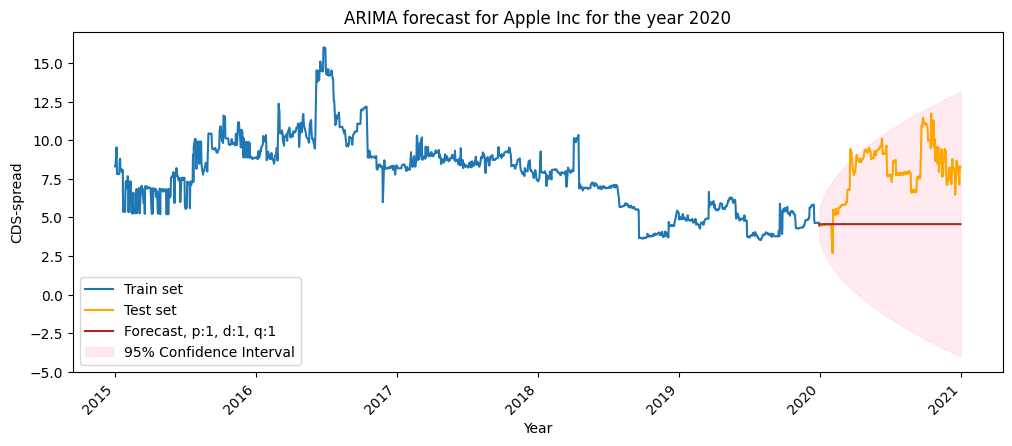

In [147]:
def SimpleARIMA(tDF, test_year, colname, plot=True, order=False):
    train_set = tDF[tDF.index.year < test_year][colname].asfreq(freq='B', method='bfill')
    test_set  = tDF[tDF.index.year == test_year][colname].asfreq(freq='B', method='bfill')

    if not order: #Select best p, d and q based on AIC fitting
        auto_model = auto_arima(train_set, seasonal=False, trace=False)
        order = auto_model.order
        model_fit = ARIMA(train_set, order=order).fit()
    else:
        model_fit = ARIMA(train_set, order=order).fit()
    
    fc = model_fit.get_forecast(len(test_set)) 
    summary = fc.summary_frame()
    summary['actual'] = test_set
    
    if plot==True:
        fig = plt.figure(figsize=(12,5))
        plt.plot(train_set, label="Train set")
        plt.plot(test_set, color='orange', label="Test set")
        plt.plot(fc.predicted_mean.index, fc.predicted_mean, label=f'Forecast, p:{order[0]}, d:{order[1]}, q:{order[2]}', color='firebrick')
        
        plt.fill_between(
            fc.predicted_mean.index,
            fc.conf_int(alpha=0.05).iloc[:, 0],
            fc.conf_int(alpha=0.05).iloc[:, 1],
            color='pink', alpha=0.3, label='95% Confidence Interval'
        )
    
        fig.autofmt_xdate(rotation=45)
        plt.xlabel("Year")
        plt.ylabel("CDS-spread")
        plt.title(f"ARIMA forecast for {tDF.Company.iloc[0]} for the year {test_year}")
        plt.legend()
        plt.show()
    return summary

frame = SimpleARIMA(ticks_DF_dict['AAPL'], 2020, "PX1")

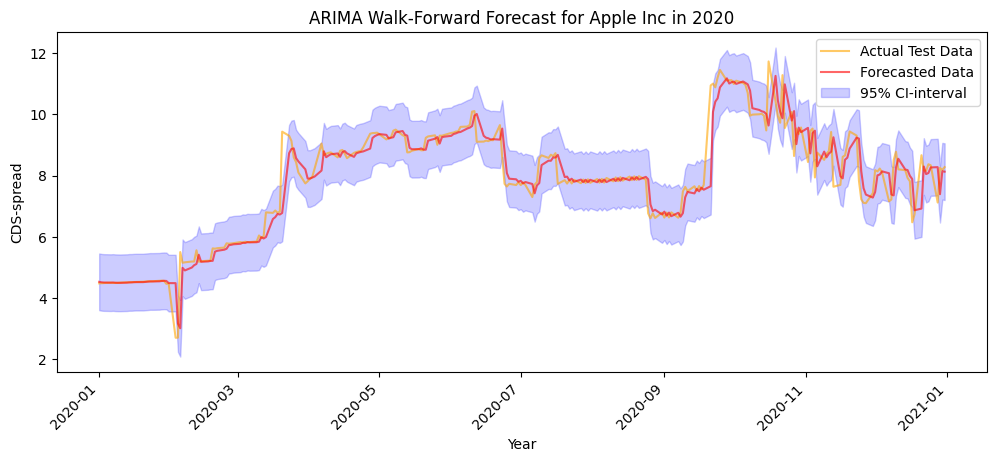

In [130]:
def WalkForwardARIMA(tDF, test_year, colname, order=False, plot=True):

    # Train-test split
    train_set = tDF[tDF.index.year < test_year][colname]#.asfreq(freq='B', method='bfill')
    test_set  = tDF[tDF.index.year == test_year][colname]#.asfreq(freq='B', method='bfill')

    if not order: #Select best p, d and q based on AIC fitting
        auto_model = auto_arima(train_set, seasonal=False, trace=False)
        order = auto_model.order

    history = list(train_set)
    model = ARIMA(train_set.values, order=order)
    model_fitted = model.fit()
    forecasts = []
    CI_ints = []
    for i in range(len(test_set)):

        forecast_result = model_fitted.get_forecast(steps=1)
        forecasts.append(forecast_result.predicted_mean[0])
        
        conf_int = forecast_result.conf_int(alpha=0.05)[0]
        CI_ints.append((conf_int[0], conf_int[1]))

        actual_value = test_set.iloc[i]
        history.append(actual_value)
        
        model_fitted = model_fitted.append([actual_value], refit=False)
    
    if plot==True:
        fig = plt.figure(figsize=(12,5))
        plt.plot(test_set.index, test_set, color='orange', alpha=0.6, label="Actual Test Data")
        plt.plot(test_set.index, forecasts, color='red', alpha=0.6, label="Forecasted Data")
        lower_bounds = [ci[0] for ci in CI_ints]
        upper_bounds = [ci[1] for ci in CI_ints]
        plt.fill_between(test_set.index, lower_bounds, upper_bounds, color='blue', alpha=0.2, label="95% CI-interval")
        fig.autofmt_xdate(rotation=45)
        plt.xlabel("Year")
        plt.ylabel("CDS-spread")
        plt.title(f"ARIMA Walk-Forward Forecast for {tDF.Company.iloc[0]} in {test_year}")
        plt.legend()
        plt.show()

    result_frame = pd.DataFrame({
        'date': test_set.index,
        'actual': test_set.values,
        'preds': forecasts,
        'lower_95': [ci[0] for ci in CI_ints],
        'upper_95': [ci[1] for ci in CI_ints]
    })
    
    return result_frame

result_frame = WalkForwardARIMA(ticks_DF_dict['AAPL'], 2020, "PX1", order=(1,1,1))

## Running the ARIMA and AR models and converting them to .csv file:

In [120]:
def parallel_walkforward_arima(tDF_dict, test_year, colname, order=(1,1,1)):
    """ Parallelized Walk-Forward ARIMA fitting and forecasting for multiple tickers. """
    results = Parallel(n_jobs=-1)(delayed(WalkForwardARIMA)(tDF, test_year, colname, order=order, plot=False) for tick, tDF in tDF_dict.items())
    return {tick: frame for tick, frame in zip(tDF_dict.keys(), results)}

In [131]:
#temp_smaller_tDF_dict = {tick: ticks_DF_dict[tick] for tick in list(ticks_DF_dict)[:8]}
ARIMA_tDF_dict = parallel_walkforward_arima(ticks_DF_dict, 2020, "PX1", order=(1,1,1))
AR_tDF_dict = parallel_walkforward_arima(ticks_DF_dict, 2020, "PX1", order=(1,1,0))

In [144]:
def createPanelDataframe(model_tDF_dict):
    for tick, DF in model_tDF_dict.items():
        DF['tick'] = tick
        if not 'panelDF' in locals():
            panelDF = DF
        else:
            panelDF = pd.concat([panelDF, DF])
    return panelDF.reset_index(drop=True)
panelARIMA = createPanelDataframe(ARIMA_tDF_dict)
panelAR = createPanelDataframe(AR_tDF_dict)

In [146]:
panelARIMA.to_csv('datasets/ARIMA/ARIMA_forecast.csv')
panelAR.to_csv('datasets/AR/AR_forecast.csv')